<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/7_multi_model_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check for causality

😈 **Task 3:** Run a Granger test between `temp` and `o3`. Is there any directional causality?

😈 **Question 3:** Why is Granger causality not the same as actual causality?


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
for col in ["no2", "temp", "no", "press"]:
    print(f"\nTesting if {col} Granger-causes o3:")
    grangercausalitytests(dataframe[['o3', col]], maxlag=4)

In [2]:
from google.colab import files
uploaded = files.upload()

Saving lstm_forecast_DENW094.csv to lstm_forecast_DENW094.csv
Saving mlp_forecast_DENW094.csv to mlp_forecast_DENW094.csv
Saving patchTST_forecast_DENW094.csv to patchTST_forecast_DENW094.csv
Saving sarima_forecast_DENW094.csv to sarima_forecast_DENW094.csv


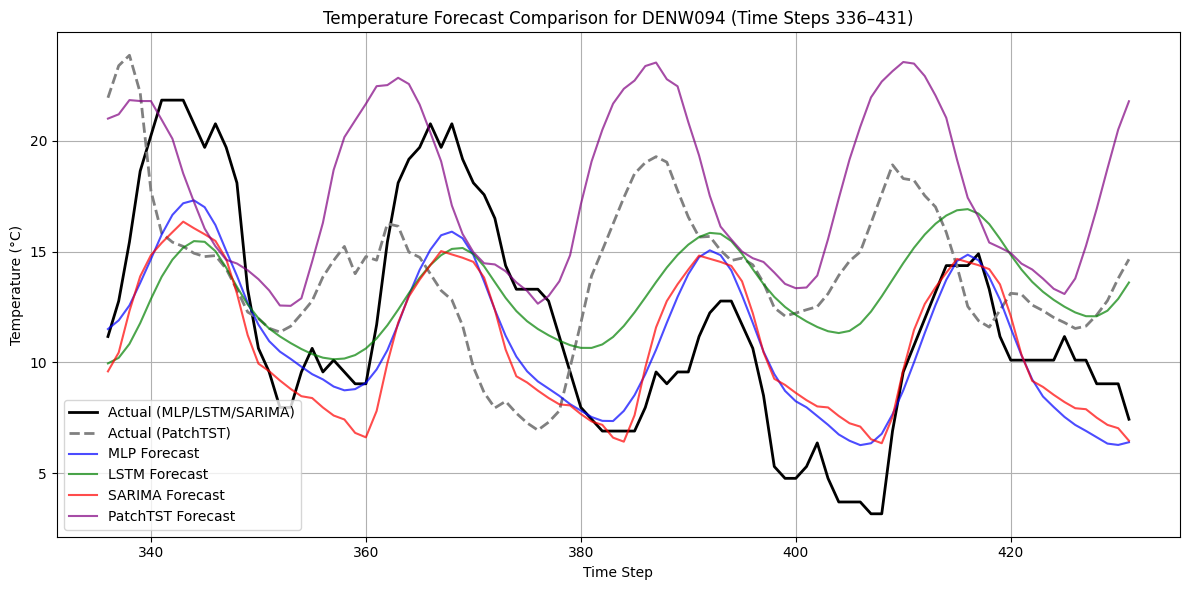

      Model    MAE   RMSE
0       MLP  2.450  2.968
1      LSTM  4.008  4.589
2    SARIMA  2.723  3.262
3  PatchTST  3.774  4.313


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import io # Import the io module

def compare_forecasts():
    """
    Compare MLP, LSTM, SARIMA, and PatchTST forecasts for DENW094.
    Returns a summary table of MAE and RMSE, and plots the forecasts.
    """
    # Load CSV files using io.BytesIO to read the byte content
    mlp_df = pd.read_csv(io.BytesIO(uploaded["mlp_forecast_DENW094.csv"]))
    lstm_df = pd.read_csv(io.BytesIO(uploaded["lstm_forecast_DENW094.csv"]))
    patchtst_df = pd.read_csv(io.BytesIO(uploaded["patchTST_forecast_DENW094.csv"]))
    sarima_df = pd.read_csv(io.BytesIO(uploaded["sarima_forecast_DENW094.csv"]))

    # Verify time steps align
    if not (mlp_df["time_step"].equals(lstm_df["time_step"]) and
            lstm_df["time_step"].equals(patchtst_df["time_step"]) and
            patchtst_df["time_step"].equals(sarima_df["time_step"])):
        raise ValueError("Time steps do not align across all models")

    # Extract actual values (assuming they’re consistent across files)
    actual_values = mlp_df["actual_values"].values  # Use MLP’s actual values as reference
    if not (np.allclose(actual_values, lstm_df["actual_values"].values) and
            np.allclose(actual_values, sarima_df["actual_values"].values)):
        print("Warning: Actual values differ slightly across MLP, LSTM, and SARIMA")
    # PatchTST actual values are different, so we’ll note this
    patchtst_actual = patchtst_df["actual_values"].values

    # Extract forecast values
    forecasts = {
        "MLP": mlp_df["forecast_values"].values,
        "LSTM": lstm_df["forecast_values"].values,
        "SARIMA": sarima_df["forecast_values"].values,
        "PatchTST": patchtst_df["forecast_values"].values
    }

    # Compute metrics
    metrics = {
        "Model": [],
        "MAE": [],
        "RMSE": []
    }
    for model, forecast in forecasts.items():
        target = patchtst_actual if model == "PatchTST" else actual_values
        mae = mean_absolute_error(target, forecast)
        rmse = np.sqrt(mean_squared_error(target, forecast))
        metrics["Model"].append(model)
        metrics["MAE"].append(mae)
        metrics["RMSE"].append(rmse)

    # Create metrics DataFrame
    metrics_df = pd.DataFrame(metrics)
    metrics_df = metrics_df.round(3)  # Round to 3 decimal places

    # Plot forecasts
    plt.figure(figsize=(12, 6))
    plt.plot(mlp_df["time_step"], actual_values, label="Actual (MLP/LSTM/SARIMA)", color="black", linewidth=2)
    plt.plot(patchtst_df["time_step"], patchtst_actual, label="Actual (PatchTST)", color="gray", linestyle="--", linewidth=2)
    plt.plot(mlp_df["time_step"], forecasts["MLP"], label="MLP Forecast", color="blue", alpha=0.7)
    plt.plot(lstm_df["time_step"], forecasts["LSTM"], label="LSTM Forecast", color="green", alpha=0.7)
    plt.plot(sarima_df["time_step"], forecasts["SARIMA"], label="SARIMA Forecast", color="red", alpha=0.7)
    plt.plot(patchtst_df["time_step"], forecasts["PatchTST"], label="PatchTST Forecast", color="purple", alpha=0.7)

    plt.xlabel("Time Step")
    plt.ylabel("Temperature (°C)")
    plt.title("Temperature Forecast Comparison for DENW094 (Time Steps 336–431)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return metrics_df

# Example usage
metrics_table = compare_forecasts()
print(metrics_table)